# <h1 style='background:#f0c2c1; border:3; border-radius: 10px; font-size:300%; font-weight: bold; color:black'><center>Predicting Machine Failure</center></h1> 

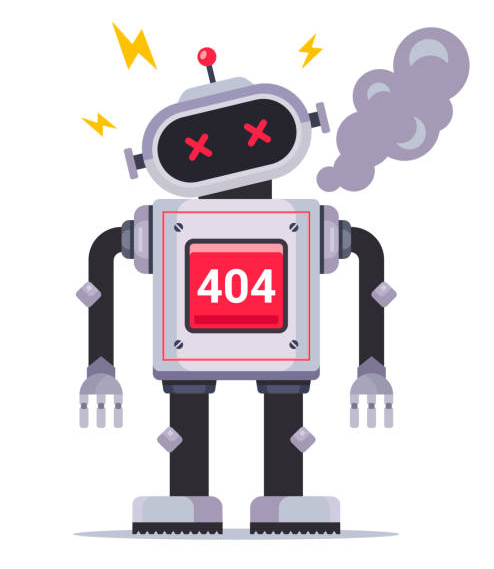


In this competition, we will be using data from the Machine Failure Predictions problem. The dataset includes information about machine failures, with the goal of predicting whether a machine will fail or not. The target variable, "Machine failure," is binary (1 for failure and 0 for non-failure).

### The dataset consists of various features, including:

* id: A unique identifier for each observation.
* Product ID: The ID of the product associated with the machine.
* Type: The type of the machine.
* Air temperature [K]: The air temperature in Kelvin.
* Process temperature [K]: The process temperature in Kelvin.
* Rotational speed [rpm]: The rotational speed of the machine in revolutions per minute.
* Torque [Nm]: The torque applied to the machine in Newton-meters.
* Tool wear [min]: The amount of wear on the machine's tool in minutes.
* TWF, HDF, PWF, OSF, RNF: Binary indicators for different protective features.
* The evaluation metric for this competition is the area under the ROC curve (AUC), which measures the performance of the predicted probabilities against the observed target values.

It's important to note that while the relationships between variables may be similar to the original dataset, they may not be exactly the same, as the data has been generated by a deep learning model.🙂 🙂 🙂 

Now lets start with EDA

#### EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tpot import TPOTClassifier
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline

# Load the training dataset
train_data = pd.read_csv('/kaggle/input/playground-series-s3e17/train.csv')
test_data =pd.read_csv('/kaggle/input/playground-series-s3e17/test.csv')

# Display the first few rows of the dataset
print(train_data.head())


   id Product ID Type  Air temperature [K]  Process temperature [K]  \
0   0     L50096    L                300.6                    309.6   
1   1     M20343    M                302.6                    312.1   
2   2     L49454    L                299.3                    308.5   
3   3     L53355    L                301.0                    310.9   
4   4     M24050    M                298.0                    309.0   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1596         36.1              140                0    0   
1                    1759         29.1              200                0    0   
2                    1805         26.5               25                0    0   
3                    1524         44.3              197                0    0   
4                    1641         35.4               34                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0   

In [2]:
# Check the shape of the dataset
print('Dataset shape:', train_data.shape)

# Check the data types of each column
print('Data types:\n', train_data.dtypes)


Dataset shape: (136429, 14)
Data types:
 id                           int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


In [3]:
# Check the summary statistics of the numerical columns
print('Summary statistics:\n', train_data.describe())


Summary statistics:
                   id  Air temperature [K]  Process temperature [K]  \
count  136429.000000        136429.000000            136429.000000   
mean    68214.000000           299.862776               309.941070   
std     39383.804275             1.862247                 1.385173   
min         0.000000           295.300000               305.800000   
25%     34107.000000           298.300000               308.700000   
50%     68214.000000           300.000000               310.000000   
75%    102321.000000           301.200000               310.900000   
max    136428.000000           304.400000               313.800000   

       Rotational speed [rpm]    Torque [Nm]  Tool wear [min]  \
count           136429.000000  136429.000000    136429.000000   
mean              1520.331110      40.348643       104.408901   
std                138.736632       8.502229        63.965040   
min               1181.000000       3.800000         0.000000   
25%               1432.

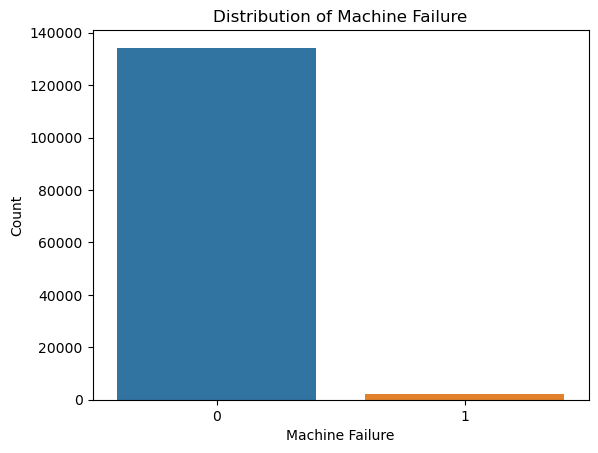

In [4]:
# Check the distribution of the target variable
sns.countplot(x='Machine failure', data=train_data)
plt.xlabel('Machine Failure')
plt.ylabel('Count')
plt.title('Distribution of Machine Failure')
plt.show()


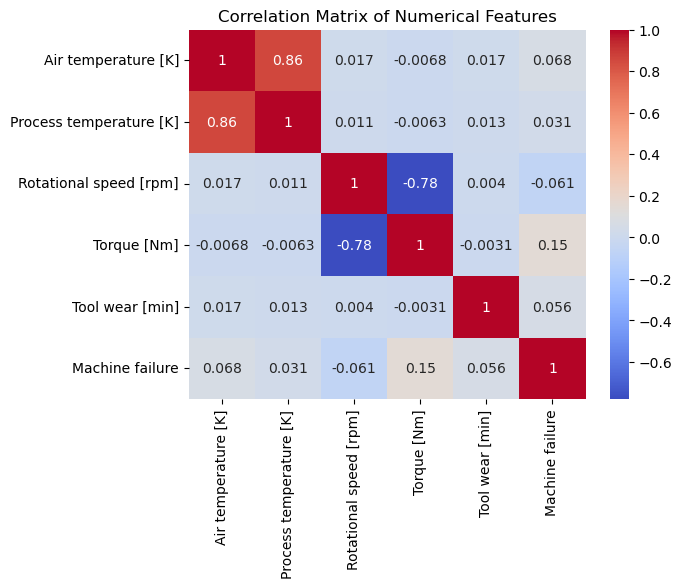

In [5]:
# Check the correlation matrix of the numerical features
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
corr_matrix = train_data[numeric_features + ['Machine failure']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


In [6]:
train_data.dtypes


id                           int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object

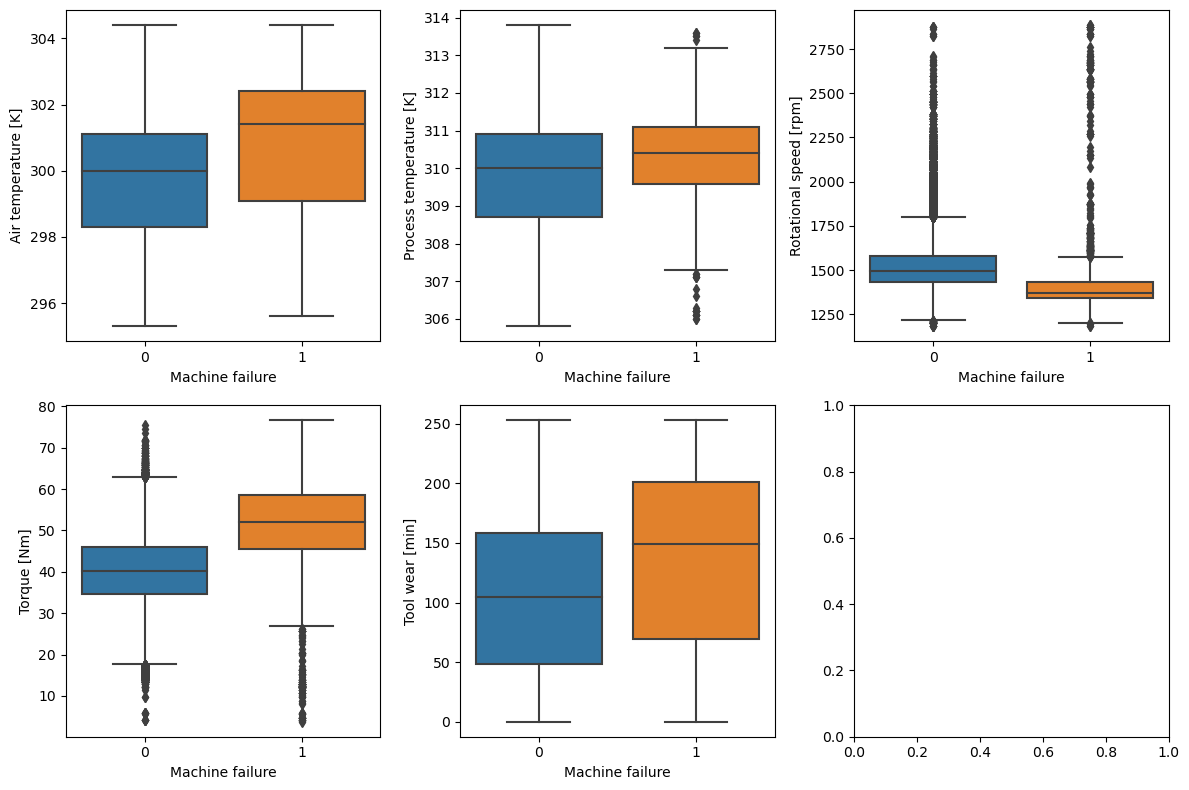

In [7]:

# Box plots of the numerical features grouped by the target variable
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, feature in enumerate(numeric_features):
    sns.boxplot(ax=axes[i // 3, i % 3], x='Machine failure', y=feature, data=train_data)
plt.tight_layout()
plt.show()

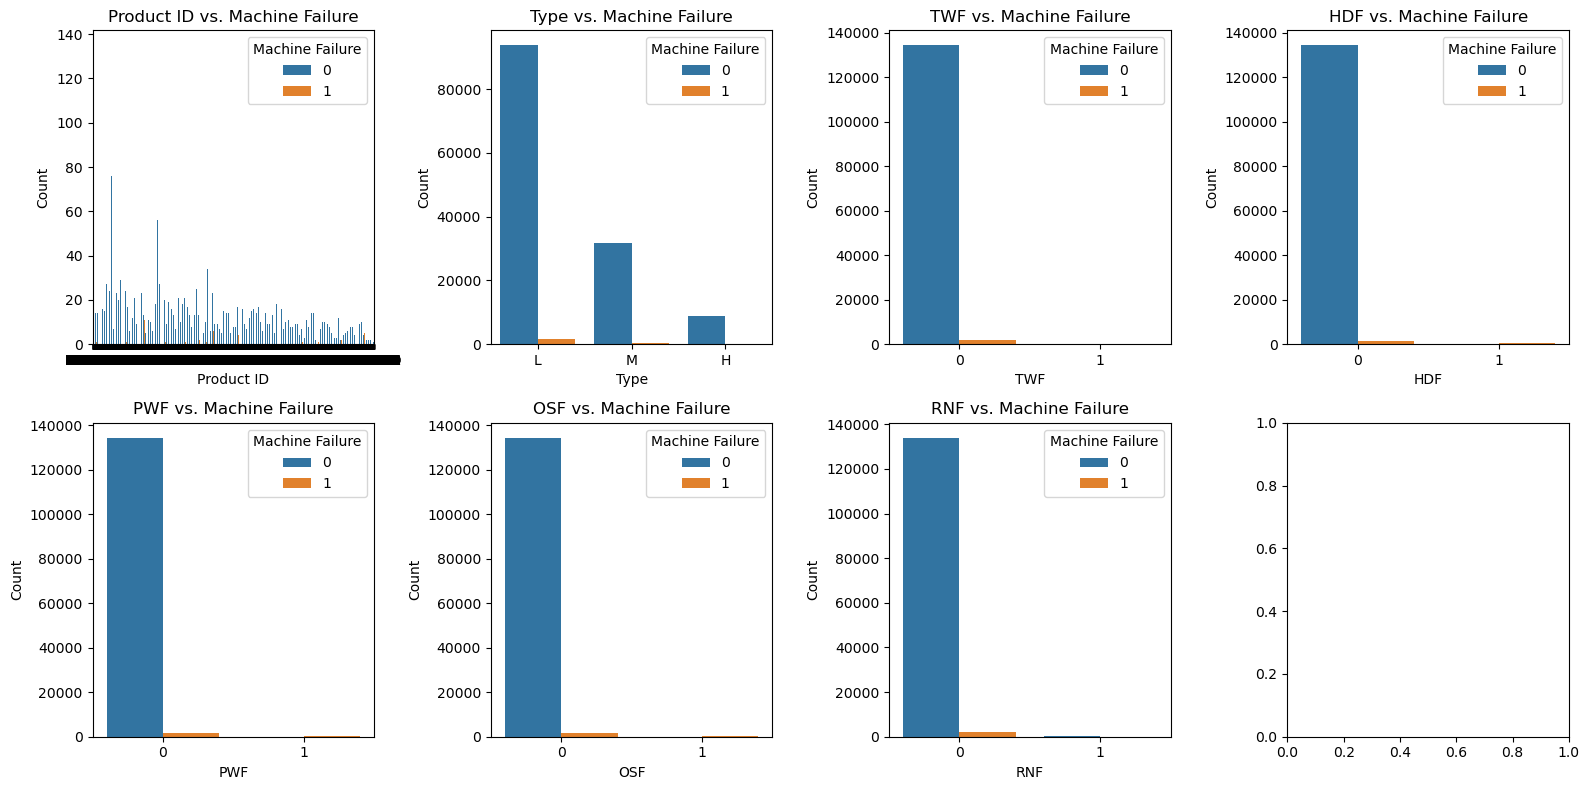

In [8]:
# Bar plots of the categorical features grouped by the target variable
categorical_features = ['Product ID', 'Type', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, feature in enumerate(categorical_features):
    sns.countplot(ax=axes[i // 4, i % 4], x=feature, hue='Machine failure', data=train_data)
    axes[i // 4, i % 4].set_title(f'{feature} vs. Machine Failure')
    axes[i // 4, i % 4].legend(title='Machine Failure')
    axes[i // 4, i % 4].set_xlabel(feature)
    axes[i // 4, i % 4].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [9]:
# Feature Engineering
train_data['Temp_difference'] = train_data['Air temperature [K]'] - train_data['Process temperature [K]']
train_data['High_rotational_speed'] = (train_data['Rotational speed [rpm]'] > train_data['Rotational speed [rpm]'].mean()).astype(int)
train_data['All_protective_features'] = (train_data['TWF'] & train_data['HDF'] & train_data['PWF'] & train_data['OSF'] & train_data['RNF']).astype(int)
train_data['Total_temperature'] = train_data['Air temperature [K]'] + train_data['Process temperature [K]']
train_data['Power'] = train_data['Rotational speed [rpm]'] * train_data['Torque [Nm]']
train_data['Wear_to_Temp_Ratio'] = train_data['Tool wear [min]'] / train_data['Process temperature [K]']

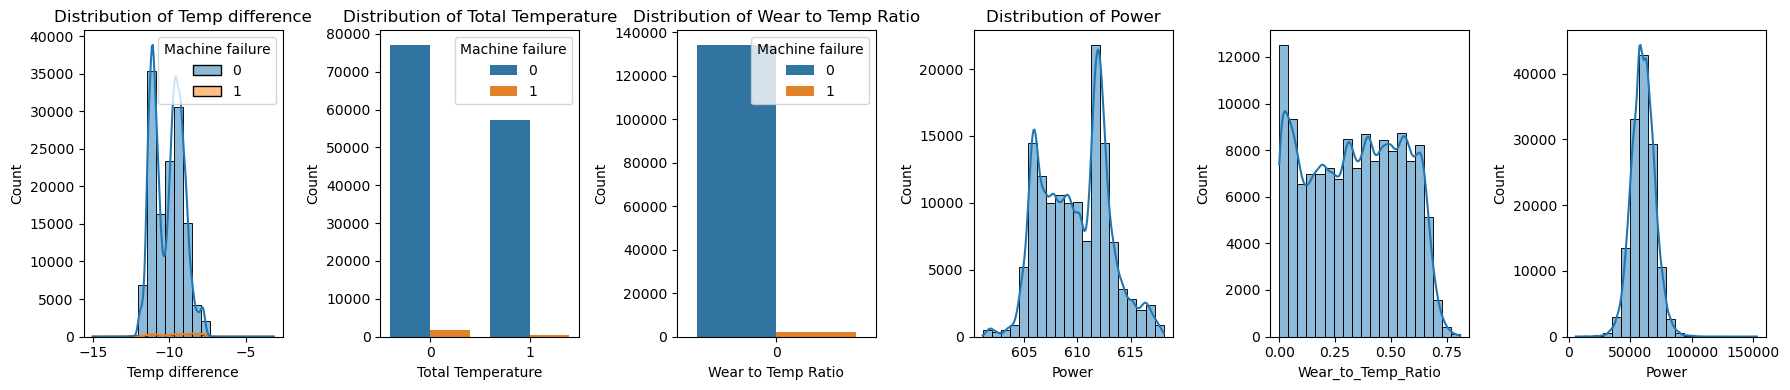

In [10]:
# Check the distribution of the new features
fig, axes = plt.subplots(1, 6, figsize=(18, 4))
sns.histplot(ax=axes[0], x='Temp_difference', data=train_data, hue='Machine failure', kde=True, bins=20)
axes[0].set_xlabel('Temp difference')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Temp difference')

sns.countplot(ax=axes[1], x='High_rotational_speed', hue='Machine failure', data=train_data)
axes[1].set_xlabel('High rotational speed')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of High rotational speed')

sns.countplot(ax=axes[2], x='All_protective_features', hue='Machine failure', data=train_data)
axes[2].set_xlabel('All protective features')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of All protective features')

sns.histplot(ax=axes[3], x='Total_temperature', data=train_data, kde=True, bins=20)
axes[1].set_xlabel('Total Temperature')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Total Temperature')

sns.histplot(ax=axes[4], x='Wear_to_Temp_Ratio', data=train_data, kde=True, bins=20)
axes[2].set_xlabel('Wear to Temp Ratio')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Wear to Temp Ratio')

sns.histplot(ax=axes[5], x='Power', data=train_data, kde=True, bins=20)
axes[3].set_xlabel('Power')
axes[3].set_ylabel('Count')
axes[3].set_title('Distribution of Power')


plt.tight_layout()
plt.show()

In [11]:
# Perform feature engineering on test_data
test_data['Temp_difference'] = test_data['Air temperature [K]'] - test_data['Process temperature [K]']
test_data['High_rotational_speed'] = (test_data['Rotational speed [rpm]'] > test_data['Rotational speed [rpm]'].mean()).astype(int)
test_data['All_protective_features'] = (test_data['TWF'] & test_data['HDF'] & test_data['PWF'] & test_data['OSF'] & test_data['RNF']).astype(int)
test_data['Total_temperature'] = test_data['Air temperature [K]'] + test_data['Process temperature [K]']
test_data['Power'] = test_data['Rotational speed [rpm]'] * test_data['Torque [Nm]']
test_data['Wear_to_Temp_Ratio'] = test_data['Tool wear [min]'] / test_data['Process temperature [K]']



In [12]:
# Drop unnecessary columns
train_data = train_data.drop(['id', 'Product ID'], axis=1)



In [13]:
# Perform one-hot encoding for 'Type' feature
type_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
type_encoded = type_encoder.fit_transform(train_data[['Type']])
type_categories = type_encoder.categories_[0]
type_encoded_df = pd.DataFrame(type_encoded, columns=[f'Type_{cat}' for cat in type_categories])
train_data = pd.concat([train_data.drop('Type', axis=1), type_encoded_df], axis=1)


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [14]:
test_id = test_data['id']

In [15]:
# Drop unnecessary columns
test_data = test_data.drop(['id', 'Product ID'], axis=1)

In [16]:
train_data.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Temp_difference',
       'High_rotational_speed', 'All_protective_features', 'Total_temperature',
       'Power', 'Wear_to_Temp_Ratio', 'Type_H', 'Type_L', 'Type_M'],
      dtype='object')

In [17]:
test_data.columns

Index(['Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF',
       'HDF', 'PWF', 'OSF', 'RNF', 'Temp_difference', 'High_rotational_speed',
       'All_protective_features', 'Total_temperature', 'Power',
       'Wear_to_Temp_Ratio'],
      dtype='object')

In [18]:
# Perform one-hot encoding for 'Type' feature in test data
test_type_encoded = type_encoder.transform(test_data[['Type']])
test_type_encoded_df = pd.DataFrame(test_type_encoded, columns=[f'Type_{cat}' for cat in type_categories])
test_data = pd.concat([test_data.drop('Type', axis=1), test_type_encoded_df], axis=1)


In [19]:
# Split the data into features and target
X = train_data.drop('Machine failure', axis=1)
y = train_data['Machine failure']


In [20]:
# Apply SMOTE for handling imbalanced target variable
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# Initialize TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=20, cv=skf, scoring='roc_auc', verbosity=2, random_state=0, n_jobs=-1)

# Train the model using AutoML
tpot.fit(X_resampled, y_resampled)

# Print the best pipeline found by TPOT
print("Best pipeline found by TPOT:")
print(tpot.fitted_pipeline_)



# Generate predictions on the test data using the trained model
predictions = tpot.predict_proba(test_data)[:, 1]

# Create submission dataframe with id and predictions
submission_df = pd.DataFrame({'id': test_id, 'Machine failure': predictions})

# Save the submission dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9902809938503061

Generation 2 - Current best internal CV score: 0.9915423597469142

Generation 3 - Current best internal CV score: 0.9915423597469142

Generation 4 - Current best internal CV score: 0.9915676512121927

Generation 5 - Current best internal CV score: 0.9950073408475175

Best pipeline: DecisionTreeClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=9, max_features=0.25, min_samples_leaf=9, min_samples_split=9, n_estimators=100, subsample=0.15000000000000002), criterion=entropy, max_depth=3, min_samples_leaf=2, min_samples_split=8)
Best pipeline found by TPOT:
Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=GradientBoostingClassifier(max_depth=9,
                                                                        max_features=0.25,
                                                                        min_samples_leaf=9,
                                   

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
